The scripts below demonstrate how to use EPCOT to predict epigenomic features, CAGE-seq, chromatin contact maps, and enhancer activity.

We run EPCOT on Google Colab notebook under GPU setting : Runtime -> Change runtime type -> select GPU

In [ ]:
!pip install kipoiseq==0.5.2 --quiet > /dev/null
!pip install einops
!pip install gdown

In [ ]:
!git clone https://github.com/zzh24zzh/EPCOT.git
!mkdir models

Cloning into 'EPCOT'...
remote: Enumerating objects: 407, done.
remote: Counting objects: 100% (407/407), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 407 (delta 179), reused 407 (delta 179), pack-reused 0
Receiving objects: 100% (407/407), 143.29 MiB | 17.14 MiB/s, done.
Resolving deltas: 100% (179/179), done.


In [ ]:
import kipoiseq
from kipoiseq import Interval
import pyfaidx
import pandas as pd
import numpy as np
from scipy.sparse import load_npz
import torch
import sys,os
import matplotlib.pyplot as plt

### Download and index reference genome file

In [ ]:
# The following codes are copied from https://github.com/deepmind/deepmind-research/blob/master/enformer/enformer-usage.ipynb

fasta_file = '/root/data/genome.fa'
!mkdir -p /root/data
!wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > {fasta_file}
pyfaidx.Faidx(fasta_file)
!ls /root/data
class FastaStringExtractor:
    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}

    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream

    def close(self):
        return self.fasta.close()
def one_hot_encode(sequence):
  return kipoiseq.transforms.functional.one_hot_dna(sequence).astype(np.float32)

fasta_extractor = FastaStringExtractor(fasta_file)

--2022-05-09 05:56:08--  http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 983659424 (938M) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>] 938.09M  27.3MB/s    in 37s     

2022-05-09 05:56:45 (25.6 MB/s) - written to stdout [983659424/983659424]

genome.fa  genome.fa.fai


### Prepare input DNA sequence and DNase-seq

In [ ]:
# load GM12878 DNase-seq in chromosome 11
GM12878_dnase=load_npz('EPCOT/examples/GM12878_dnase_chr11.npz').toarray().squeeze()
GM12878_dnase.shape

(135086000,)

In [ ]:
def pad_seq_matrix(matrix,pad_left,pad_right, pad_len=300):
    # add flanking region to each sample
    dmatrix = np.concatenate((pad_left, matrix[:, :, -pad_len:]), axis=0)[:-1, :, :]
    umatrix = np.concatenate((matrix[:, :, :pad_len], pad_right), axis=0)[1:, :, :]
    return np.concatenate((dmatrix, matrix, umatrix), axis=2)

def pad_signal_matrix(matrix, pad_len=300):
    paddings = np.zeros(pad_len).astype('float32')
    dmatrix = np.vstack((paddings, matrix[:, -pad_len:]))[:-1, :]
    umatrix = np.vstack((matrix[:, :pad_len], paddings))[1:, :]
    return np.hstack((dmatrix, matrix, umatrix))

def generate_input(chrom,start,end,dnase):
    target_interval = kipoiseq.Interval(chrom,start, end)
    sequence_one_hot = one_hot_encode(fasta_extractor.extract(target_interval))
    sequence_matrix=sequence_one_hot.reshape(-1, 1000,4).swapaxes(1, 2)

    pad_interval = kipoiseq.Interval(chrom,start-300, start)
    seq_pad_left=np.expand_dims(one_hot_encode(fasta_extractor.extract(pad_interval)).swapaxes(0,1),0)

    pad_interval = kipoiseq.Interval(chrom,end, end+300)
    seq_pad_right=np.expand_dims(one_hot_encode(fasta_extractor.extract(pad_interval)).swapaxes(0,1),0)
    dnase_interest=np.expand_dims(pad_signal_matrix(dnase.reshape(-1,1000))[start//1000:end//1000],1)
    seq_interest=pad_seq_matrix(sequence_matrix,seq_pad_left,seq_pad_right)
    inputs=torch.tensor(np.concatenate((seq_interest,dnase_interest),axis=1)).float()
    return inputs
def plot_bindings(ax,val,chr,start,end,color='#17becf'):
    ax.fill_between(np.arange(val.shape[0]), 0, val, color=color)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks(np.arange(0,val.shape[0],val.shape[0]//5))
    ax.set_ylim(0,1)
    ax.set_xticklabels(np.arange(start,end,(end-start)//5))
    ax.margins(x=0)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

#region of interest, the start and end position should be divisible by 1000
chrom,start,end=['chr11',46750000,47750000]
inputs=generate_input(chrom,start,end,GM12878_dnase).to(device)
inputs.shape

cuda:0


torch.Size([1000, 5, 1600])

### Download and load pre-training model

In [ ]:
# Download model from google drive
!gdown 1_YfpNSv-2ABQV2qSyBxem-y7aJFyRNzz --output models/pretrain_dnase.pt

Downloading...
From: https://drive.google.com/uc?id=1_YfpNSv-2ABQV2qSyBxem-y7aJFyRNzz
To: /content/models/pretrain_dnase.pt
100% 100M/100M [00:00<00:00, 232MB/s] 


In [ ]:
import sys
sys.path.append('EPCOT/')
from pretraining.model import build_model
import argparse
def parser_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--num_class', default=245, type=int)
    parser.add_argument('--seq_length', default=1600, type=int)
    parser.add_argument('--rnn_embedsize', default=320, type=int)
    parser.add_argument('--nheads', default=4, type=int)
    parser.add_argument('--hidden_dim', default=512, type=int)
    parser.add_argument('--dim_feedforward', default=1024, type=int)
    parser.add_argument('--enc_layers', default=1, type=int)
    parser.add_argument('--dec_layers', default=2, type=int)
    parser.add_argument('--dropout', default=0.2, type=float)
    parser.add_argument('--fea_pos', default=False, action='store_true')
    args, unknown = parser.parse_known_args()
    return args
def get_args():
    args = parser_args()
    return args
args = get_args()
pretrain_model= build_model(args)
pretrain_model.to(device)
pretrain_model.load_state_dict(torch.load('models/pretrain_dnase.pt'))


<All keys matched successfully>

### Make epigenomic feature prediction (EFP task)

In [ ]:
pretrain_model.eval()
with torch.no_grad():
    pred_epi = torch.sigmoid(pretrain_model(inputs))
pred_epi=pred_epi.detach().cpu().numpy()

In [ ]:
with open('EPCOT/Profiles/epigenomes.txt', 'r') as f:
    epigenomes = f.read().splitlines()

CTCF


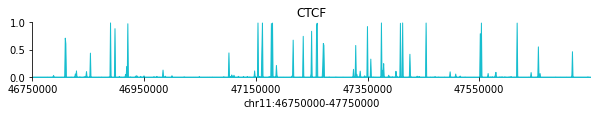

In [ ]:
epi_idx=0
print(epigenomes[epi_idx])
fig,ax=plt.subplots(figsize=(10,1))
val=pred_epi[:,0]
plot_bindings(ax,val, chrom,start,end)
ax.set_xlabel('%s:%s-%s'%(chrom,start,end))
ax.set_title(epigenomes[epi_idx])
plt.show()

### Load Downstream model to predict CAGE-seq (CAGE-seq GEP task)

The downstream model to predict 1kb-resolution CAGE-seq takes the input of 250kb genomic regions and predicts the CAGE-seq in the centered 200kb region.

In [ ]:
# Download model from google drive
!gdown 1eP-ruOcywlGeQIRuVwWk_QFc4z9j4-jF --output models/cage_transformer.pt

Downloading...
From: https://drive.google.com/uc?id=1eP-ruOcywlGeQIRuVwWk_QFc4z9j4-jF
To: /content/models/cage_transformer.pt
100% 119M/119M [00:00<00:00, 176MB/s]


In [ ]:
from gex.cage.model import build_pretrain_model_cage
def parser_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--num_class', default=245, type=int)
    parser.add_argument('--seq_length', default=1600, type=int)
    parser.add_argument('--rnn_embedsize', default=320, type=int)
    parser.add_argument('--bins', type=int, default=250)
    parser.add_argument('--crop', type=int, default=25)
    parser.add_argument('--nheads', default=4, type=int)
    parser.add_argument('--hidden_dim', default=512, type=int)
    parser.add_argument('--embed_dim', default=360, type=int)
    parser.add_argument('--dim_feedforward', default=1024, type=int)
    parser.add_argument('--enc_layers', default=1, type=int)
    parser.add_argument('--dec_layers', default=2, type=int)
    parser.add_argument('--dropout', default=0.2, type=float)
    parser.add_argument('--fea_pos', default=False, action='store_true')
    parser.add_argument('--mode', type=str, default='transformer')
    parser.add_argument('--fine_tune', default=False, action='store_true')
    parser.add_argument('--pretrain_path', default=None)
    args, unknown = parser.parse_known_args()
    return args
def get_args():
    args = parser_args()
    return args

args = get_args()
cage_model= build_pretrain_model_cage(args)
cage_model.cuda()
cage_model.load_state_dict(torch.load('models/cage_transformer.pt'))
cage_model.eval()
# enter region of interest ('cage_end-cage_start' should be divisible by 200000)
cage_chrom,cage_start,cage_end=['chr11',46750000,47750000]

input_start,input_end=cage_start-25000,cage_end+25000
cages=[]
inputs=[]
for s in range(input_start,input_end-200000,200000):
    e=s+250000
    cage_inputs=generate_input(cage_chrom,s,e,GM12878_dnase).to(device)
    inputs.append(cage_inputs)
inputs=torch.stack(inputs)
pred_cage=cage_model(inputs).detach().cpu().numpy().flatten()

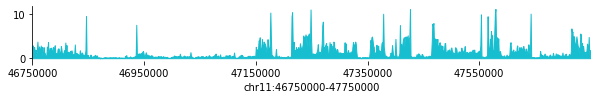

In [ ]:
def plot_cage(ax,val,chr,start,end,color='#17becf'):
    ax.fill_between(np.arange(val.shape[0]), 0, val, color=color)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xlabel('%s:%s-%s'%(chr,start,end))
    ax.set_xticks(np.arange(0,val.shape[0],val.shape[0]//5))
    ax.set_xticklabels(np.arange(start,end,(end-start)//5))
    ax.margins(x=0)
fig,ax=plt.subplots(figsize=(10,1))
plot_cage(ax,pred_cage,cage_chrom,cage_start,cage_end)
plt.show()

## Hi-C chromatin contact map prediction (Hi-C COP task)

In [ ]:
# Download models trained on GM12878 and HFFc6 Hi-C
!gdown 1ia-ZoSoiZGDFPnZcySzMpirovHhulRfH --output models/hic_HFF_transformer.pt
!gdown 1EXm2AjqqO-UtLi2pprbDEb1gPXrxI3aW --output models/hic_GM12878_transformer.pt

Downloading...
From: https://drive.google.com/uc?id=1ia-ZoSoiZGDFPnZcySzMpirovHhulRfH
To: /content/models/hic_HFF_transformer.pt
100% 119M/119M [00:00<00:00, 195MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EXm2AjqqO-UtLi2pprbDEb1gPXrxI3aW
To: /content/models/hic_GM12878_transformer.pt
100% 119M/119M [00:00<00:00, 127MB/s]


In [ ]:
from chrom_organization.hic.model import build_pretrain_model_hic
def parser_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--num_class', default=245, type=int)
    parser.add_argument('--seq_length', default=1600, type=int)
    parser.add_argument('--rnn_embedsize', default=320, type=int)
    parser.add_argument('--bins', type=int, default=200)
    parser.add_argument('--crop', type=int, default=4)
    parser.add_argument('--nheads', default=4, type=int)
    parser.add_argument('--hidden_dim', default=512, type=int)
    parser.add_argument('--embed_dim', default=256, type=int)
    parser.add_argument('--dim_feedforward', default=1024, type=int)
    parser.add_argument('--enc_layers', default=1, type=int)
    parser.add_argument('--dec_layers', default=2, type=int)
    parser.add_argument('--dropout', default=0.2, type=float)
    parser.add_argument('--accum_iter', default=2, type=int)
    parser.add_argument('--fea_pos', default=False, action='store_true')
    parser.add_argument('--fine_tune', default=False, action='store_true')
    parser.add_argument('--trunk',  type=str, default='transformer')
    parser.add_argument('--pretrain_path', default=None)
    args, unknown = parser.parse_known_args()
    return args
def get_args():
    args = parser_args()
    return args
args = get_args()
hic_model= build_pretrain_model_hic(args)
hic_model.cuda()

# load GM12878 model
hic_model.load_state_dict(torch.load('models/hic_GM12878_transformer.pt'))

61


<All keys matched successfully>

In [ ]:
# regions of interest, where 'hic_end-hic_start' should be divisible by 1000000
hic_chrom,hic_start,hic_end=['chr11',46750000,47750000]
inputs=[]
for s in np.arange(hic_start,hic_end,1000000):
    inputs.append(generate_input(hic_chrom,s,s+1000000,GM12878_dnase))
inputs=torch.stack(inputs).float().to(device)

In [ ]:
hic_model.eval()
pred_hic=hic_model(inputs).detach().cpu().numpy()
pred_hic.shape

(1, 18528, 1)

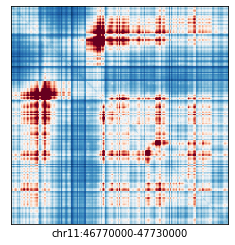

In [ ]:
def arraytouptri(arrays):
    effective_lens=args.bins-2*args.crop
    triu_tup = np.triu_indices(effective_lens)
    temp=np.zeros((effective_lens,effective_lens))
    temp[triu_tup]=arrays
    return temp
def complete_mat(mat):
    temp = mat.copy()
    np.fill_diagonal(temp,0)
    mat= mat+temp.T
    return mat
def plot_hic(ax, mat,cmap='RdBu_r', vmin=0, vmax=5):
    ax.imshow(mat,cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_xticks([])
    ax.set_yticks([])
pred_hic_uptri=arraytouptri(pred_hic[0].squeeze())
fig,ax=plt.subplots()
plot_hic(ax,complete_mat(pred_hic_uptri))
ax.set_xlabel('%s:%s-%s'%(hic_chrom,hic_start+20000,hic_end-20000))
plt.show()

##Visualize results above in one plot

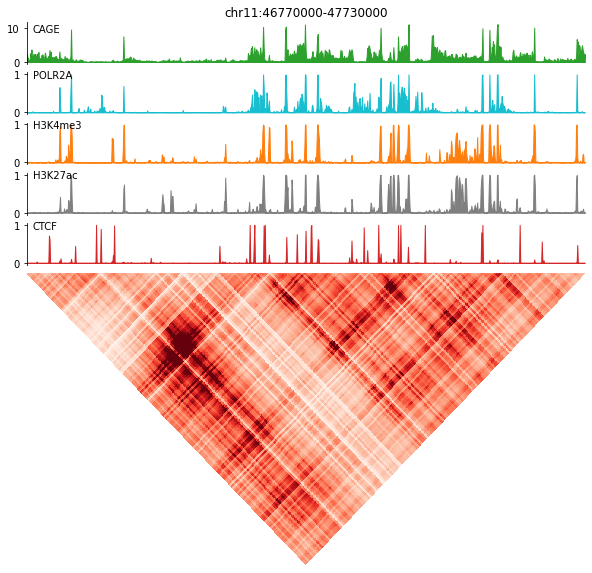

In [ ]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(11, 5)

ax_hic = fig.add_subplot(gs[5:11, :5])
axs = [fig.add_subplot(gs[i,:5]) for i in range(5)]
bin_coords = np.true_divide(np.arange(192), np.sqrt(2))
x, y = np.meshgrid(bin_coords, bin_coords)
sin45 = np.sin(np.radians(45))
x, y = x * sin45 + y * sin45, x * sin45 - y * sin45
ax_hic.pcolormesh(x, y, complete_mat(pred_hic_uptri), cmap='Reds', vmin=0, vmax=5)
ax_hic.set_ylim(-96,0)
cage=pred_cage[20:-20]
axs[0].fill_between(np.arange(cage.shape[0]), 0, cage, color='#2ca02c')
axs[0].text(10,9,'CAGE', ha='left')
val=pred_epi[:,7][20:-20]
axs[1].fill_between(np.arange(val.shape[0]), 0, val, color='#17becf')
axs[1].text(10,0.9,'POLR2A', ha='left')
val=pred_epi[:,-3][20:-20]
axs[2].fill_between(np.arange(val.shape[0]), 0, val,color='#ff7f0e')
axs[2].text(10,0.9,'H3K4me3', ha='left')
val = pred_epi[:, -6][20:-20]
axs[3].fill_between(np.arange(val.shape[0]), 0, val, color='#7f7f7f')
axs[3].text(10,0.9,'H3K27ac', ha='left')
val = pred_epi[:, 0][20:-20]
axs[4].fill_between(np.arange(val.shape[0]), 0, val, color='#d62728')
axs[4].text(10,0.9,'CTCF', ha='left')
for ax in axs:
    ax.margins(x=0)
    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
ax_hic.axis('off')
axs[0].set_title('%s:%s-%s'%(hic_chrom,hic_start+20000,hic_end-20000))
plt.show()

## Cross-cell type prediction in HCT116

For cross-cell type prediction, it is important that the normalized DNase-seq in training cell types and testing cell types have similar data scales, if not, maybe some normalization methods are needed to the DNase-seq of testing cell types (like quantile normalization mentioned in [Anchor](https://genome.cshlp.org/content/29/2/281.full).)

In [ ]:
# Hi-C cross-cell type predicition
# load models trained on GM12878 and HFF, for other models you can also download them from google drives
hic_model= build_pretrain_model_hic(args)
hic_model.cuda()
hic_model.load_state_dict(torch.load('models/hic_GM12878_transformer.pt'))
hic_model.eval()
hic_model2= build_pretrain_model_hic(args)
hic_model2.cuda()
hic_model2.load_state_dict(torch.load('models/hic_HFF_transformer.pt'))
hic_model2.eval()
# HUVEC_dnase=load_npz('EPCOT/examples/HUVEC_dnase_chr11.npz').toarray().squeeze()
HCT116_dnase=load_npz('EPCOT/examples/HCT116_dnase_chr11.npz').toarray().squeeze()
hic_chrom,hic_start,hic_end=['chr11',86750000,87750000]
inputs=[]
for s in np.arange(hic_start,hic_end,1000000):
    inputs.append(generate_input(hic_chrom,s,s+1000000,HCT116_dnase))
inputs=torch.stack(inputs).float().to(device)
pred_hic=hic_model(inputs).cpu().data.detach().numpy()
pred_hic1=hic_model2(inputs).cpu().data.detach().numpy()
pred_hic=(pred_hic+pred_hic1)/2

61
61


In [ ]:
# cross-cell type epigenomic feature prediction
# region of interest
chrom,start,end=['chr11',86770000,87730000]
inputs=generate_input(chrom,start,end,HCT116_dnase).to(device)
inputs.shape
with torch.no_grad():
    pred_epi = torch.sigmoid(pretrain_model(inputs))
pred_epi=pred_epi.detach().cpu().numpy()


In [ ]:
# Cross-cell type CAGE-seq prediction
HCT116_dnase=load_npz('EPCOT/examples/HCT116_dnase_chr11.npz').toarray().squeeze()
cage_chrom,cage_start,cage_end=['chr11',86750000,87750000]

input_start,input_end=cage_start-25000,cage_end+25000
cages=[]
inputs=[]
for s in range(input_start,input_end-200000,200000):
    e=s+250000
    cage_inputs=generate_input(cage_chrom,s,e,HCT116_dnase).to(device)
    inputs.append(cage_inputs)
inputs=torch.stack(inputs)
pred_cage=cage_model(inputs).detach().cpu().numpy().flatten()
pred_cage.shape

(1000,)

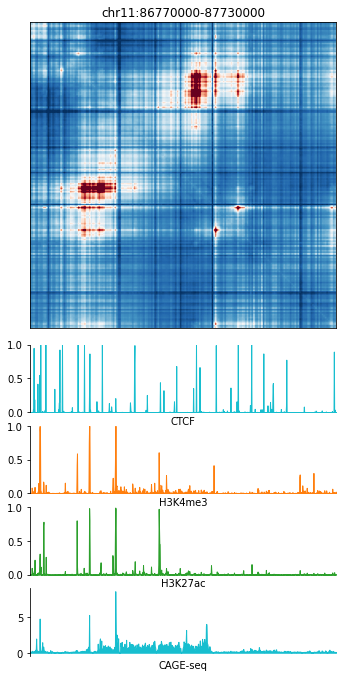

In [ ]:
fig = plt.figure(figsize=(5, 9.5))
gs = GridSpec(8, 5, wspace = 0.75, hspace = 0.2, left = 0.05, top = 0.98, right = 0.9, bottom = 0.05)
ax_hic = fig.add_subplot(gs[:4, :5])
ax_track= [fig.add_subplot(gs[4+i:5+i,:5]) for i in range(4)]
plot_hic(ax_hic,complete_mat(pred_hic_uptri),vmin=0,vmax=3)

epis=['CTCF','H3K4me3','H3K27ac','CAGE-seq']
plot_bindings(ax_track[0],pred_epi[:,0], chrom,start,end)
plot_bindings(ax_track[1],pred_epi[:,-3], chrom,start,end,color='tab:orange')
plot_bindings(ax_track[2],pred_epi[:,-6], chrom,start,end,color='tab:green')
plot_cage(ax_track[3],pred_cage[20:-20],cage_chrom,cage_start,cage_end)
for i in range(len(ax_track)):
  ax_track[i].set_xticks([])
  ax_track[i].set_xlabel(epis[i])
ax_hic.set_title('%s:%s-%s'%(chrom,start,end))
plt.show()
